In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib
import matplotlib.pyplot as plt
from itertools import *
from pylab import *
import time
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay, ConvexHull
from collections import defaultdict, Counter
import itertools
from itertools import combinations
from shapely.geometry import LineString, MultiPolygon, MultiPoint, Point
import collections
from matplotlib.collections import LineCollection
from scipy.ndimage import label
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import networkx as nwx
import math
import random
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import cv2
import os

matplotlib.rcParams.update({'font.size': 13})
matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'

coords_gemma = np.genfromtxt('gemma_1.txt', delimiter='\t')
coords_boundary = np.genfromtxt('boundary_gemma_1.txt', delimiter='\t')

points = list(coords_gemma/5)

boundary_points = list(coords_boundary/5)

gemma_size = len(points)
points = points + boundary_points

#plt.figure(3)
#plt.scatter(*zip(*points))
#plt.scatter(*zip(*boundary_points))
#plt.show()

extra_points = 2000;
points = np.array(points)

#plt.scatter(points[:, 0],points[:, 1])

tri = Delaunay(points)
vor = Voronoi(points)
neiList=defaultdict(set)

new_len = gemma_size

def compute_gabriel_graph(points):
    #delaunay triangulation
    delaunay = Delaunay(points)
    edges = []

    # iteration through the edges of the Delaunay triangulation
    for simplex in delaunay.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                p1, p2 = points[simplex[i]], points[simplex[j]]
                mid_point = (p1 + p2)/2
                radius = np.linalg.norm(p1 - p2)/2

                is_gabriel = True

                #check if any other point lies within the circle
                for k in range(len(points)):
                    if k != simplex[i] and k != simplex[j]:  #exclude points on the current edge
                        if np.linalg.norm(points[k] - mid_point) < radius:
                            is_gabriel = False
                            break

                if is_gabriel:
                    edges.append((simplex[i], simplex[j]))

    return edges

for Q in tri.simplices:
    for i,j in itertools.combinations(Q,2):
        if (i < gemma_size) & (j < gemma_size):
            neiList[i].add(j)
            neiList[j].add(i)
        
def index_vertices(a1,a2): ##this computes the corresponding index for vertices between cells (a1,a2)
    ss = -1; BB = [];       #is there a better way?
    for Q in tri.simplices:
        ss = ss + 1
        for i,j in itertools.combinations(Q,2):
            if ([i,j] == [a1,a2]) or ([i,j] == [a2,a1]):
                BB.append(ss)
    return np.array(BB)

length = {}  ###lenght of shared sides between cells k and j
sum_len_neig = {} ###sum of these lengths shared between neighbours
    
for k in range(0,new_len):
    sl = 0;
    for j in neiList[k]:
        LL = vor.vertices[index_vertices(k,j)]
        length[k,j] = np.sqrt((LL[0] - LL[1])[0]**2 + (LL[0] - LL[1])[1]**2)
        sl = sl + length[k,j]
    sum_len_neig[k] = sl

perimeter = np.zeros(vor.npoints)  
area = np.zeros(vor.npoints)

for i, reg_num in enumerate(vor.point_region):
    indices = vor.regions[reg_num]
    if -1 in indices: # some regions can be opened
        #perimeter[i] = perimeter[i]  ## = np.infnp.inf
        area[i] = area[i] ## = np.inf
    else:
        #perimeter[i] = ConvexHull(vor.vertices[indices]).area ##in 2D this is the perimeter
        area[i] = ConvexHull(vor.vertices[indices],qhull_options='QJ').volume ##in 2D this is the area
        #hull = ConvexHull(vor.vertices[indices])
        
p = tri.points[tri.simplices]

# Triangle vertices
A = p[:,0,:].T
B = p[:,1,:].T
C = p[:,2,:].T

# See http://en.wikipedia.org/wiki/Circumscribed_circle#Circumscribed_circles_of_triangles
# The following is just a direct transcription of the formula there

a1 = A - C
b1 = B - C

def dot2(u, v):
    return u[0]*v[0] + u[1]*v[1]

def cross2(u, v, w):
    """u x (v x w)"""
    return dot2(u, w)*v - dot2(u, v)*w

def ncross2(u, v):
    """|| u x v ||^2"""
    return sq2(u)*sq2(v) - dot2(u, v)**2

def sq2(u):
    return dot2(u, u)

cc = cross2(sq2(a1)*b1 - sq2(b1)*a1, a1, b1) / (2*ncross2(a1, b1)) + C

# grab the Voronoi edges
vc = cc[:,tri.neighbors]
vc[:,tri.neighbors == -1] = np.nan # edges at infinity, plotting those would need more work...



/var/folders/_r/xkdhrm6554zgpd1gd9935s3m0000gq/T/ipykernel_59428/3098302179.py:149: RuntimeWarning: divide by zero encountered in divide
  cc = cross2(sq2(a1)*b1 - sq2(b1)*a1, a1, b1) / (2*ncross2(a1, b1)) + C
/var/folders/_r/xkdhrm6554zgpd1gd9935s3m0000gq/T/ipykernel_59428/3098302179.py:149: RuntimeWarning: invalid value encountered in divide
  cc = cross2(sq2(a1)*b1 - sq2(b1)*a1, a1, b1) / (2*ncross2(a1, b1)) + C


In [2]:
def diff(x,k):
    K = 0; J = 0;
    for i in neiList[k]:
        K = K + (x[i] - x[k])*length[k,i]/sum_len_neig[k]
    return K
    
#model rhizoids simplified
a0 = 0.4; a = 2; b = 0.1; g0 = 0.1; g = 0.78; kr = 1.2; kf = 2;
kc = 1;  nr = 4; nf = 4; dm = 1; dr = 0.1; df = 1;
D = 0.6;

dt = 0.1; total_time = 500;

noise = 1;
p = 0.12

m0 = 0; R0 = 1.5; F0 = 0;

#np.random.seed(15)

m = m0*(noise*(np.random.random(gemma_size + extra_points)))
R = R0*(noise*(np.random.random(gemma_size + extra_points)))
F = F0*(noise*(np.random.random(gemma_size + extra_points)))

#m = m0*(1 + noise*(np.random.uniform(-1,1, size = gemma_size + extra_points)))
#R = R0*(1 + noise*(np.random.uniform(-1,1, size = gemma_size + extra_points)))
#F = F0*(1 + noise*(np.random.uniform(-1,1, size = gemma_size + extra_points)))

morph = np.zeros(gemma_size + extra_points)
a_morph = np.zeros(gemma_size + extra_points)

Rrand = np.random.choice([1,0.], size=gemma_size + extra_points, p=[p, 1-p])

T = np.zeros(int(total_time/dt)+1)
MM = np.zeros((gemma_size + extra_points,int(total_time/dt)+1))
RR = np.zeros((gemma_size + extra_points,int(total_time/dt)+1))
FF = np.zeros((gemma_size + extra_points,int(total_time/dt)+1))
MORPH = np.zeros((gemma_size + extra_points,int(total_time/dt)+1))

t = 0; s = -1;
Rrand = Rrand[0:new_len]
m = m[0:new_len]; R = R[0:new_len]; F = F[0:new_len]; morph = morph[0:new_len]; a_morph = a_morph[0:new_len]
MM = MM[0:new_len,:]; RR = RR[0:new_len,:]; FF = FF[0:new_len,:]; MORPH = MORPH[0:new_len,:]

a_morph[0] = 50
a_morph[4] = 50
Dmorph = 1

while t <= total_time:
    t = t + dt
    for j in range(new_len):
        morph[j] = morph[j] + dt*( a_morph[j] - 0.4*morph[j] + Dmorph*diff(morph,j) ) 
    MORPH[:,s] = morph[:]

t = 0;

thres = 0.015 ###this ensures we have 145 cells in total (similar to 147 on average from the experiments)
A = a*((morph**12)/(thres**12 + morph**12))

#activate for random model (and remember to comment the dynamics of the other variables, and time does not matter, so set it short)
#R = Rrand

m[A<1] = 0.
R[A<1] = 0.
F[A<1] = 0.

while t <= total_time:
    t = t + dt
    T[s] = t
    s = s + 1

    for j in range(new_len):

        m[j] = m[j] + dt*( a0 + A[j]*(R[j]**nr)/(kr**nr + R[j]**nr) - kc*m[j]*F[j] - dm*m[j] )
        R[j] = R[j] + dt*( b*m[j] - dr*R[j] )
        F[j] = F[j] + dt*( g0 + g*(R[j]**nf)/(kf**nf + R[j]**nf) + D*diff(F,j) - df*F[j] )

        #to check if the neighbours work
        #R[0] = 1
        #R[list(neiList[70])] = 2
    
    MM[:,s] = m[:]
    RR[:,s] = R[:]
    FF[:,s] = F[:]


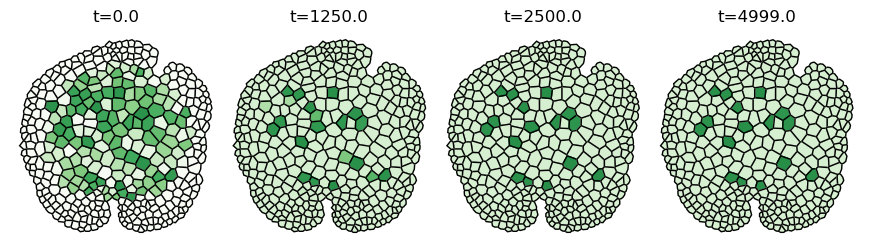

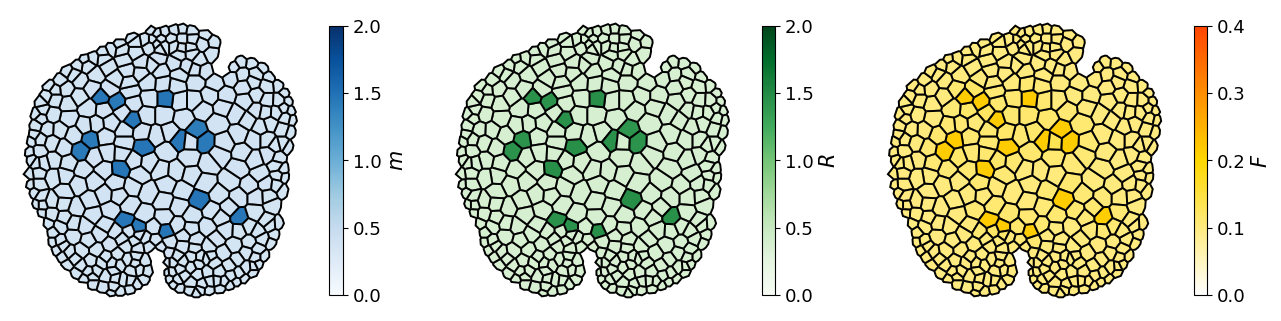

In [3]:
fig1, axs = plt.subplots(1,4,figsize = (11,7))
fig1.subplots_adjust(wspace = 0.01)

cmap1 = 'Blues'
cmap2 = 'Greens'
cmap3 = matplotlib.colors.LinearSegmentedColormap.from_list("", ['w','gold','orangered'])

norm1 = mpl.colors.Normalize(vmin=0., vmax=2, clip=True)
norm2 = mpl.colors.Normalize(vmin=0., vmax=2, clip=True)
norm3 = mpl.colors.Normalize(vmin=0, vmax=0.4, clip=True)

sm1 = cm.ScalarMappable(norm=norm1, cmap=cmap1)
sm2 = cm.ScalarMappable(norm=norm2, cmap=cmap2)
sm3 = cm.ScalarMappable(norm=norm3, cmap=cmap3)

sm1.set_array([]); sm2.set_array([]); sm3.set_array([]);

s = -1;
for t in [0,int(total_time/dt)/4,int(total_time/dt)/2,int(total_time/dt)-1]:
    s = s + 1

    for k in range(new_len):
        region = vor.regions[vor.point_region[k]]
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            axs[s].fill(*zip(*polygon), color=sm2.to_rgba(RR[k,int(t)]))
            poly = patches.Polygon(polygon, edgecolor='black', fill=None, lw=1)
            axs[s].add_patch(poly)
            axs[s].set_aspect('equal', adjustable='box')
            axs[s].axis('off')
            axs[s].set_title(r't=%.1f'%t, fontsize = 12)
            plt.xticks([])
            plt.yticks([])
            #axs[s].scatter(*zip(*points))
            #axs[s].plot(points[0:new_len,0], points[0:new_len,1], '.')

plt.savefig('realistic_gemma_full.pdf', transparent = True, bbox_inches='tight')

plt.show()

variables = {'m': m, 'R': R, 'F': F}
colormaps = {'m': sm1, 'R': sm2, 'F': sm3}

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(wspace = 0.15)

for ax, (var_name, var_data) in zip(axes, variables.items()):
    for k in range(new_len):
        region = vor.regions[vor.point_region[k]]
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            ax.fill(*zip(*polygon), color=colormaps[var_name].to_rgba(var_data[k]))
            poly = patches.Polygon(polygon, edgecolor='black', fill=None, lw=1.4)
            ax.add_patch(poly)
    cbar = plt.colorbar(colormaps[var_name], ax = ax, shrink = 0.7)
    cbar.ax.set_ylabel('$%s$' %var_name, fontsize = 15)
    
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])



Proportion of rhizoid cells in ROI: 0.1103448275862069
145


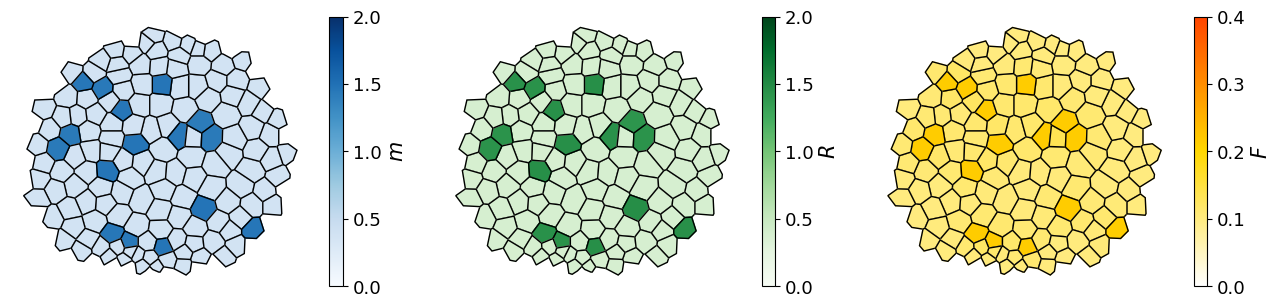

In [4]:
ROI = np.where(A>1)

all_indices = ROI[0]
rhizoid_indices = np.where((A>1)&(R>1))[0]
rhizoid_cells = R > 1
epidermal_indices = np.where((A>1)&(R<1))[0]
density_rhizoid_cells = len(rhizoid_indices)/len(all_indices)
rhizoid_points = points[rhizoid_indices]

print('Proportion of rhizoid cells in ROI:', density_rhizoid_cells)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(wspace = 0.15)

points_ROI = points[all_indices]

for ax, (var_name, var_data) in zip(axes, variables.items()):
    for k in all_indices:
        region = vor.regions[vor.point_region[k]]
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            ax.fill(*zip(*polygon), color=colormaps[var_name].to_rgba(var_data[k]))
            poly = patches.Polygon(polygon, edgecolor='black', fill=None, lw=1.)
            ax.add_patch(poly)
    cbar = plt.colorbar(colormaps[var_name], ax = ax, shrink = 0.7)
    cbar.ax.set_ylabel('$%s$' %var_name, fontsize = 15)
    #ax.scatter(points_ROI[:,0],points_ROI[:,1], color='k', s = 2)
    
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

print(len(points_ROI))

plt.savefig('part_gemma_full.pdf', transparent = True, bbox_inches='tight')

plt.show()

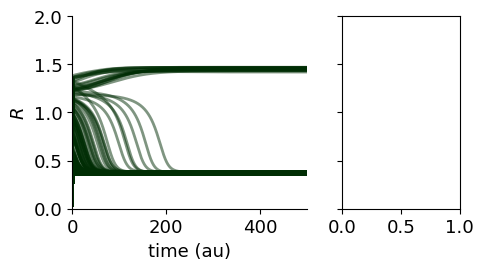

In [5]:
ff, (ax1,ax2) = plt.subplots(1,2,figsize = (5,2.5), sharey = True, width_ratios=[2, 1])

for i in range(0,gemma_size):
    ax1.plot(T[0:-2],MM[i,0:-2], color = 'xkcd:dark forest green', alpha = 0.5, linewidth = 2)

ax1.set_xlabel('time (au)')
ax1.set_ylabel(r'$R$')
#ax1.grid(alpha = 0.2, linewidth = 1.);
ax1.axis([0,total_time, 0,2])

ax1.spines[['right', 'top']].set_visible(False)

plt.savefig('dynamics_gemma_patterns.pdf', transparent = True, bbox_inches='tight')



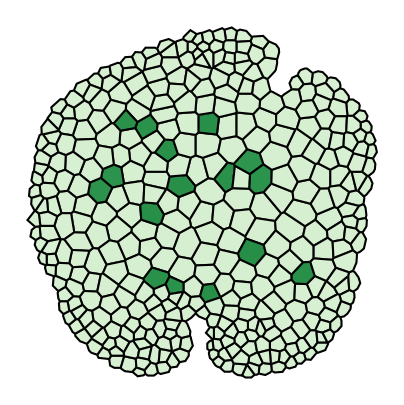

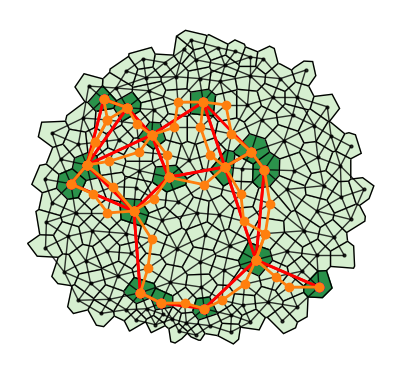

In [6]:
gabriel_rhizoid = compute_gabriel_graph(rhizoid_points)

G_rhizoid = nwx.Graph()
for point in rhizoid_points:
    G_rhizoid.add_node(tuple(point))
G_rhizoid.add_edges_from(gabriel_rhizoid)

G = nwx.Graph()

for simplex in tri.simplices:
    for i in range(len(simplex)):
        for j in range(i + 1, len(simplex)):
            p1 = tuple(points[simplex[i]])
            p2 = tuple(points[simplex[j]])
            distance = np.linalg.norm(points[simplex[i]] - points[simplex[j]])
            G.add_edge(p1, p2, weight=distance)

def find_all_cliques(G):
    cliques = list(nwx.find_cliques(G))
    return cliques

gabriel_rhizoid_cliques = find_all_cliques(G_rhizoid)

fig2, ax1 = plt.subplots(1,1,figsize = (5,5))
fig2.subplots_adjust(wspace = 0.1)

for k in range(new_len):
    region = vor.regions[vor.point_region[k]]
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        ax1.fill(*zip(*polygon), color=sm2.to_rgba(R[k]))
        poly = patches.Polygon(polygon, edgecolor='black', fill=None, lw=1.5)
        ax1.add_patch(poly)

#plt.plot(points[0:new_len,0], points[0:new_len,1], 'r.')

for edge in gabriel_rhizoid:
    p1, p2 = edge
    point1 = rhizoid_points[p1]
    point2 = rhizoid_points[p2]
    #ax1.plot([point1[0], point2[0]], [point1[1], point2[1]], 'ro-', linewidth=1.5)

#for i in rhizoid_indices:
    #ax1.text(points[i,0], points[i,1], str(i), fontsize=13, ha='right', color='red')
    #ax1.plot(points[i,0], points[i,1], color = 'fuchsia', markersize = 5, marker = 'o')

ax1.set_aspect('equal', adjustable='box')

#plt.xlim(-0.1, 10.1)
#plt.ylim(-0.1, 10.1)
ax1.axis('off')
plt.xticks([])
plt.yticks([])

plt.savefig('gabriel_graph.pdf', transparent = True, bbox_inches='tight')

plt.show()


#to compute rhizoid cell neighbours of other rhizoid cells
neighbors = {label: [] for label in rhizoid_indices}

#find neighbors from the Gabriel graph
for clique in gabriel_rhizoid_cliques:
    for i in range(len(clique)):
        for j in range(len(clique)):
            if i != j:
                p1 = rhizoid_indices[clique[i]]
                p2 = rhizoid_indices[clique[j]]
                neighbors[p1].append(p2)

#remove duplicates in neighbors
for key in neighbors.keys():
    neighbors[key] = list(set(neighbors[key]))

def get_neighbors(label):
    if label in neighbors:
        return neighbors[label]
    else:
        return []

rhizoid_neighbors = {label: get_neighbors(label) for label in rhizoid_indices}

#####

#find clusters of rhizoid cells
def find_clusters(rhizoid_cells, neiList):
    visited = np.zeros(len(rhizoid_cells), dtype=bool)
    clusters = []

    def dfs(cell, cluster):
        stack = [cell]
        while stack:
            current = stack.pop()
            if not visited[current]:
                visited[current] = True
                cluster.append(current)
                stack.extend([nei for nei in neiList[current] if rhizoid_cells[nei] and not visited[nei]])

    for i in range(len(rhizoid_cells)):
        if rhizoid_cells[i] and not visited[i]:
            cluster = []
            dfs(i, cluster)
            clusters.append(cluster)

    return clusters

clusters = find_clusters(rhizoid_cells, neiList)

#compute cluster sizes
cluster_sizes = [len(cluster) for cluster in clusters]

#count the number of clusters of each size
cluster_size_counts = defaultdict(int)
for size in cluster_sizes:
    cluster_size_counts[size] += 1

sizes = sorted(cluster_size_counts.keys())
counts = [cluster_size_counts[size] for size in sizes]


#shortest path between two cells
def find_shortest_path(G, start_label, end_label):
    start_point = tuple(points[start_label])
    end_point = tuple(points[end_label])
    shortest_path = nwx.shortest_path(G, source=start_point, target=end_point, weight='weight')
    return shortest_path

all_pairs = set()

for label in rhizoid_indices:
    for neighbor in rhizoid_neighbors[label]:
        pair = tuple(sorted((label, neighbor)))
        all_pairs.add(pair)
                
len_shortest_path = np.zeros(len(all_pairs));

fig2, ax1 = plt.subplots(1,1,figsize = (5,5))
fig2.subplots_adjust(wspace = 0.1)

for k in all_indices:
    region = vor.regions[vor.point_region[k]]
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        ax1.fill(*zip(*polygon), color=sm2.to_rgba(R[k]))
        poly = patches.Polygon(polygon, edgecolor='black', fill=None, lw=1.)
        ax1.add_patch(poly)

for edge in gabriel_rhizoid:
    p1, p2 = edge
    point1 = rhizoid_points[p1]
    point2 = rhizoid_points[p2]
    ax1.plot([point1[0], point2[0]], [point1[1], point2[1]], 'ro-', linewidth=2)

for i in rhizoid_indices:
    #ax1.text(points[i,0], points[i,1], str(i), fontsize=13, ha='right', color='red')
    ax1.plot(points[i,0], points[i,1], color = 'fuchsia', markersize = 6, marker = 'o')

ax1.set_aspect('equal', adjustable='box')

ax1.axis('off')
plt.xticks([])
plt.yticks([])

middle_points = points[all_indices]
Gmiddle = nwx.Graph()

for simplex in tri.simplices:
    for i in range(len(simplex)):
        for j in range(i + 1, len(simplex)):
            p1 = tuple(points[simplex[i]])
            p2 = tuple(points[simplex[j]])

            if p1 in map(tuple, middle_points) and p2 in map(tuple, middle_points):
                distance = np.linalg.norm(points[simplex[i]] - points[simplex[j]])
                Gmiddle.add_edge(p1, p2, weight=distance)

pos = {tuple(middle_points[i]): middle_points[i] for i in range(len(middle_points))}

nwx.draw(Gmiddle, pos, with_labels=False, node_size = 4, node_color="k", edge_color="k",alpha=0.8)

all_pairs = list(all_pairs)

kk = -1
for l,j in all_pairs:
    
    kk = kk + 1

    start_label = l
    end_label = j

    shortest_path = find_shortest_path(G, start_label, end_label)

    path_points = np.array(shortest_path)
    ax1.plot(path_points[:, 0], path_points[:, 1], color='C1', linewidth=2, marker='o', alpha = 1)
    
    len_shortest_path[kk] = len(shortest_path)-1

#ax1.grid(alpha = 0.2, linewidth = 1.);
plt.savefig('shortest_path.pdf', transparent = True, bbox_inches='tight')

plt.show()

145


/var/folders/_r/xkdhrm6554zgpd1gd9935s3m0000gq/T/ipykernel_59428/601953834.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Greens_r', 3)


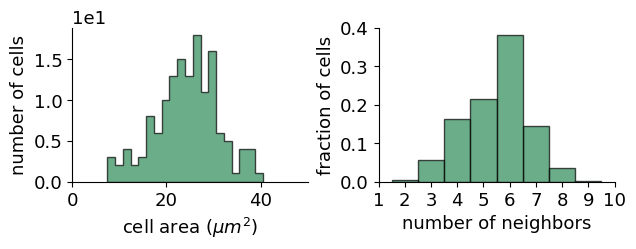

In [7]:
f, (ax,ax1) = plt.subplots(1,2, figsize=(7,2.))
f.subplots_adjust(wspace=0.3)

area_all = area[all_indices]
area_rhizoid = area[rhizoid_indices]
area_epidermal = area[epidermal_indices]

nbins = 20

cmap = cm.get_cmap('Greens_r', 3)

print(len(area_all))

ax.hist(area_all, bins=nbins, color='seagreen', alpha = 0.7, linewidth = 1, edgecolor = 'k', histtype = 'stepfilled',  label = 'all cells')
#ax.hist(area_epidermal, bins = nbins, color = cmap(1), alpha = 0.6, linewidth = 0.8, edgecolor = 'k',histtype = 'stepfilled', label = 'epidermal')
#ax.hist(area_rhizoid, bins = nbins, color = cmap(2), alpha = 0.6, linewidth = 0.8, edgecolor = 'k',histtype = 'stepfilled', label = 'rhizoid')

ax.spines[['right', 'top']].set_visible(False)

#ax.legend(loc = 'upper right', fontsize = 9)
ax.set_xlabel(r'cell area ($\mu m^2$)')
ax.set_ylabel('number of cells')
ax.set_xlim(0,50); 
#ax.set_ylim(0,0.1)

##################


neighbor_counts = [len(k) for k in neiList.values()]
neighbor_distribution = Counter(neighbor_counts)

x = list(neighbor_distribution.keys())
y = list(neighbor_distribution.values())

ax1.spines[['right', 'top']].set_visible(False)

ax1.bar(x, y/sum(y), width=1, color='seagreen', alpha = 0.7, linewidth = 1, edgecolor = 'k')

ax1.set_xlabel('number of neighbors')
ax1.set_ylabel('fraction of cells')
ax1.set_ylim(0,0.4)

ax1.set_xticks([1,2,3,4,5,6,7,8,9,10])  # Set x-ticks to be the number of neighbors
ax1.set_xlim(1,10)  # Set x-ticks to be the number of neighbors

from matplotlib.ticker import ScalarFormatter

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))

plt.savefig('model_cell_properties.pdf', transparent = True, bbox_inches='tight')


plt.show()